In [1]:
library(Seurat)
library(dplyr)
library(ggtree)
library(ggplot2)
library(ape)

Attaching SeuratObject


载入程辑包：'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

ggtree v3.2.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and othe

In [2]:
func_1 <- function(x){
    return((x-min(x))/(max(x)-min(x)))
}
func_2 <- function(x){
    if (min(x) < 0){
    return(x+abs(min(x)))}
    else{
        return(x)
    }
}

In [3]:
treeInPaper_hc <- function(x){ x %>%
                      t() %>%
                      cor(method = 'pearson') %>%
                      as.dist() %>%
                      hclust(,method = 'average')}

In [4]:
#https://github.com/sebepedroslab/Stylophora_single_cell_atlas/blob/857eb758bb6886bd91482cfe601e9bd5f56b12de/metacell_downstream_functions/Tree_functions.R
#' Build tree by ensemble clustering using downsampling variable genes
#'
#' @param x matrix, genes in rows, cell types (or metacells) in columns
#' @param n numer of iterations of clutering that will be performed 
#'   to calculate coocurence
#' @param k numeric, number of clusters into which to cut trees 
#'   to get clusters for which the co-occurrence will be calculated
#' @param h numeric, height at which to cut trees to get clusters for
#'   which the co-occurrence will be calculated
#' @param vargenes character, optinal variable genes for sampling
#' @param p numeric, between 0 and 1, fraction of genes for sampling
#' @param clustering_method character, method to use for clustering, 
#'   for available options see method argument in `?hclust()`
#' @param cor_method character, see method argument in `?cor()`
#' 
treeFromEnsembleClustering=function(
  x, n=1000, k=NULL, h=NULL, vargenes=NULL, p=0.75, bootstrap=FALSE,
  clustering_algorithm="hclust", clustering_method="average",cor_method="pearson"
) {
  ensemble_hc=vector(mode="list",length=n)
  hs <- rep(h,n)[1:n]
  if (clustering_algorithm=="hclust") {
    for (i in 1:n) { 
      if (bootstrap==TRUE) p=1
      ids=sample(vargenes,p*length(vargenes),replace=bootstrap)
      hc=hclust(as.dist(1-cor(
        x[ids,],method=cor_method
      )), clustering_method)
      hc$height <- round(hc$height, 6)
      ensemble_hc[[i]]=cutree(hc,h=hs[i])
    }
  } else if (clustering_algorithm=="nj") {
    for (i in 1:n) {
      if (bootstrap==TRUE) p=1
      ids=sample(vargenes,p*length(vargenes),replace=bootstrap)
      hc=as.hclust(ape::multi2di(phytools::force.ultrametric(ape::root(ape::nj(as.dist(1-cor(
        x[ids,],method=cor_method
      ))),outgroup=1),method="extend")))
      ensemble_hc[[i]]=cutree(hc,h=hs[i])
    }
  }
  coocmat=matrix(0,nrow=ncol(x),ncol=ncol(x))
  colnames(coocmat)=colnames(x)
  rownames(coocmat)=colnames(x)
  for (i in 1:ncol(x)) {
    for (j in 1:ncol(x)) {
      if (!i<j) {
        a=colnames(x)[i]; b=colnames(x)[j]
        cooc=sum(unlist(lapply(ensemble_hc, function(el) el[a]==el[b])))
        coocmat[i,j]=cooc
        coocmat[j,i]=cooc
      }
    }
  }
  if (clustering_algorithm=="hclust") {
    tree=ape::as.phylo(hclust(dist(coocmat), method=clustering_method))
  } else if (clustering_algorithm=="nj") {
    tree=ape::as.phylo(nj(dist(coocmat)))
  }
  return(list(
    tree=tree,
    cooccurrence=coocmat
  ))
}
                               
plotTreeMatrix <- function(
  mat, tree, build_tree=TRUE, rev=TRUE,
  ctcol, hmapcol=NULL, name, 
  out_name, width=7, height=5,
  show_row_names = TRUE, row_names_side = "left", 
  show_column_names = TRUE, column_names_side="bottom",
  annotation_side = c("right", "top")
) {
  if (is.null(hmapcol))
    hmapcol=colorRamp2(
      c(0,100,200,400,600,700,800,900,1000),
      colors=c(c("white",'#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#990000'))
    )
  if (build_tree) {
    gt <- ggplot_build(ggtree::ggtree(tree)+theme_tree2()+geom_tiplab()); gtd <- gt$data[[3]]; data.table::setDT(gtd); data.table::setorder(gtd,"y")
    labels_ord <- gtd$label
  } else {
    labels_ord <- tree$tip.label
  }
  if (rev) labels_ord <- rev(labels_ord)
  row_ha = ComplexHeatmap::rowAnnotation(
    ct = labels_ord, col= list(ct = ctcol[labels_ord]),
    border = TRUE, show_legend = FALSE, show_annotation_name = FALSE
  )
  col_ha = ComplexHeatmap::columnAnnotation(
    ct = labels_ord, col= list(ct = ctcol[labels_ord]), 
    border = TRUE, show_legend = FALSE, show_annotation_name = FALSE
  )
  bottom_annotation <- NULL
  top_annotation <- NULL
  right_annotation <- NULL
  left_annotation <- NULL
  if(length(annotation_side)>0) {
    if (any(grepl("top",annotation_side))) top_annotation <- col_ha
    if (any(grepl("bottom",annotation_side))) bottom_annotation <- col_ha
    if (any(grepl("right",annotation_side))) right_annotation <- row_ha
    if (any(grepl("left",annotation_side))) left_annotation <- row_ha
  }
  hm <- ComplexHeatmap::Heatmap(
    mat[labels_ord,labels_ord],
    name = name,
    col = hmapcol,
    border = TRUE, rect_gp =  grid::gpar(col = "gray66", lwd = 0.2),
    cluster_rows = FALSE, cluster_columns = FALSE, 
    show_row_dend = FALSE, show_column_dend = FALSE,
    row_names_gp = grid::gpar(col = ctcol[labels_ord]),
    column_names_gp = grid::gpar(col = ctcol[labels_ord]),
    bottom_annotation = bottom_annotation, top_annotation = top_annotation,
    right_annotation = right_annotation, left_annotation = left_annotation,
    show_row_names=show_row_names, row_names_side = row_names_side,
    show_column_names = show_column_names, column_names_side=column_names_side
  )
  pdf(out_name,width=width,height=height)
  print(hm)
  dev.off()
}

saveTreeFiles <- function(
  tree_rds, ctcol, out_dir,mc_fp,var_genes, save_nexus=FALSE, scale_branches=FALSE, 
  width_tree=10, height_tree=14, width_polytree=8, height_polytree=12
) {
  method <- stringr::str_extract(tree_rds,"nj|hclust(?=\\.RDS)"); if(is.na(method)) method="hclust"
  tree <- readRDS(tree_rds)
  treename <- stringr::str_remove(basename(tree_rds),"\\.RDS")
  iter <- 1000
  support_trees <- vector(mode="list",length=iter)
  p <- 0.5
  for(i in 1:iter){ support_trees[[i]]=treeDownsampling(mc_fp,vargenes=var_genes,p=p,method=method) }
  support=ape::prop.clades(tree, support_trees)
  tip_color=ctcol[tree$tip.label]
  if (scale_branches==TRUE)
    tree <- ape::compute.brlen(tree, 1)
  pdf(sprintf("%s/%s.pdf",out_dir,treename),height=height_tree,width=width_tree,useDingbats=TRUE)
  plot(tree,tip.color=tip_color,cex=1.5)
  ape::drawSupportOnEdges(support,col="black",bg="white",frame="circle")
  dev.off()
  if (save_nexus) {
    col_tib <- tibble(color=gplots::col2hex(tip_color),label=names(tip_color))
    tree_tib <- as_tibble(tree)
    tree_tib$support <- c(rep(NA, length(tree$tip.label)), support)
    tree_full_tib <- treeio::full_join(tree_tib,col_tib, by="label")
    col_labs <- unlist(lapply(1:nrow(tree_full_tib), function(i) {
      lb=tree_full_tib$label[i]
      cl=tree_full_tib$color[i]
      if (!is.na(cl)) {
        sprintf("%s[&!color=%s]",lb,cl)
      } else {
        lb
      }
    }))
    tree_full_tib$label <- col_labs
    tree_full_dat <- treeio::as.treedata(tree_full_tib)
    treeio::write.beast(tree_full_dat, file=file.path(sprintf("%s/%s.beast",out_dir,treename)))
  }
  polit <- 0.1
  supp <- polit*iter
  polytree <- di2multi_support(tree, support, supp)
  tree_tib <- as_tibble(polytree)
  missing_terminal_nodes <- tree_tib$branch.length<0.01 & !is.na(tree_tib$label)
  tree_tib$branch.length[missing_terminal_nodes] <- tree_tib$branch.length[missing_terminal_nodes]+1
  polytree <- ape::as.phylo(tree_tib)
  if (scale_branches==TRUE)
    polytree <- ape::compute.brlen(polytree, 1)
  pdf(
    sprintf("%s/%s_polytomies_support%.2f.pdf",out_dir,treename,polit),
    height=height_polytree,width=width_polytree,useDingbats=TRUE
  )
  par(mar=rep(2, 4))
  plot(polytree, main=sprintf("Polytomies: support < %.0f%%",polit*100), cex=1.5, tip.color=tip_color)
  dev.off()
  if (save_nexus) {
    col_tib <- tibble(color=gplots::col2hex(tip_color),label=names(tip_color))
    tree_col_tib <- treeio::full_join(polytree,col_tib,by="label")
    tree_tib <- as_tibble(polytree)
    tree_tib_support <- c(rep(NA, length(polytree$tip.label)), support)
    if (length(tree_tib_support)-nrow(tree_tib)==1) {
      tree_tib_support <- tree_tib_support[2:length(tree_tib_support)]
    }
    tree_tib$support <- tree_tib_support
    tree_full_tib <- treeio::full_join(tree_tib,col_tib, by="label")
    col_labs <- unlist(lapply(1:nrow(tree_full_tib), function(i) {
      lb=tree_full_tib$label[i]
      cl=tree_full_tib$color[i]
      if (!is.na(cl)) {
        sprintf("%s[&!color=%s]",lb,cl)
      } else {
        lb
      }
    }))
    tree_full_tib$label <- col_labs
    tree_full_dat <- treeio::as.treedata(tree_full_tib)
    treeio::write.beast(tree_full_dat,file=file.path(sprintf("%s/%s_politomies%.2f.beast",out_dir,treename,polit)))
  }
}

                               
treeDownsampling=function(x,vargenes,p=0.75,method="hclust",clustering_method="average") {
  if (method=="hclust") {
    ape::as.phylo(hclust(as.dist(1-cor(x[sample(vargenes,p*length(vargenes)),],method="pearson")), clustering_method)) 
  }else if (method=="nj") {
    ape::as.phylo(nj(as.dist(1-cor(x[sample(vargenes,p*length(vargenes)),],method="pearson")))) 
  }
}

getTreeSupport <- function(
  tree,mc_fp,var_genes, scale_branches=FALSE,method = 'hclust',p=0.5,iter=1000,clustering_method
) {
  #method <- stringr::str_extract(tree_rds,"nj|hclust(?=\\.RDS)"); if(is.na(method)) method="hclust"
  #tree <- readRDS(tree)
  #treename <- stringr::str_remove(basename(tree_rds),"\\.RDS")
  #iter <- 1000
  support_trees <- vector(mode="list",length=iter)
  #p <- 0.5
  for(i in 1:iter){ support_trees[[i]]=treeDownsampling(mc_fp,vargenes=var_genes,p=p,method=method,clustering_method=clustering_method) }
  support=ape::prop.clades(tree, support_trees)
  support[is.na(support)] <- round(mean(support,na.rm = T),digits = 0)
  message(sum(support/10 < 50))
  #tip_color=ctcol[tree$tip.label]
  if (scale_branches==TRUE)
    tree <- ape::compute.brlen(tree, 1)
  #pdf(sprintf("%s/%s.pdf",out_dir,treename),height=height_tree,width=width_tree,useDingbats=TRUE)
  plot(tree,cex=1.5)
  ape::drawSupportOnEdges(support/iter*100,col="black",bg="white",frame="circle")
  #dev.off()
  return(support)
}
                               
#' Turn low supported nodes to politomies
#' 
#' @param tree object of class 'phylo'
#' @param support numeric, vector of support values
#' @param thrs numeric, support threshold value, nodes with support 
#'   lower than this value will be turned into politomies
#'   
#' @return object of class 'phylo'
#' 
di2multi_support <- function(tree, support, thrs) {
  
  # add support to tree
  support[is.na(support)] <- 0
  tree_tb <- as_tibble(tree)
  tree_tb$support <- c(rep(NA, length(tree$tip.label)), support)
  
  # set low support branches to 0
  topoly <- !is.na(tree_tb$support) & tree_tb$support<thrs
  tree_tb$branch.length[topoly] <- 0
  tree_new <- ape::as.phylo(tree_tb)
  
  # turn short branches into politomies
  polytree <- ape::di2multi(tree_new, tol=0.0)
  #plot(polytree)
  return(polytree)
  
}


#' Get gap genes for internal nodes in a tree
#' 
#' @param tree
#' @param feature_matrix, rows should be features (genes or motifs) and columns should be 
#'   tips of the tree; data should be log2 scaled
# @param feature_inclusion_ths numeric, threshold to consider a feature (gene, motif) (default: 1)
#' @param branch_length_ths numeric, threshold for selecting long branches (default: 0.1)
#' @param feature_in_thrs min threshold median value for feature in 
#'   the columns of feature_matrix in the selected node split
#' @param feature_out_thrs max threshold median value for features in 
#'   the columns of feature_matrix outside of selected node split
#' @param method,methodbg character, "absolute" or "median"
#' @param ncores integer (default: `detectCores()-1`)
#' @param verbose logical (default: FALSE)
#' 
tree_gap_genes <- function(
  tree, feature_matrix, branch_length_thrs=0.1,
  feature_in_thrs = 1.5, feature_out_thrs = 1,
  method="absolute", methodbg="absolute", abs_leakyness=0, abs_leakynessbg=0.05,
  ncores=detectCores()-1, verbose=FALSE
) {
  
  # get tree data
  tree_tb=as_tibble(tree)
  treet=tidytree::as.treedata(tree)
  
  # get the order of the tips
  tip_labels <- treet@phylo$tip.label
  is_tip <- treet@phylo$edge[,2] <= length(tip_labels)
  ordered_tips <- treet@phylo$edge[is_tip, 2]
  
  # get the ordered tip labels
  tip_labels <- treet@phylo$tip.label[ordered_tips]
  
  # select iternal nodes with large branch lengths. CRITICAL!!
  # (start at n_tips + 2 (because the first internal node is the whole tree!)
  nodes <- 1:nrow(tree_tb)
  nodes_above_ths <- tree_tb$branch.length[(length(tip_labels)+2):nrow(tree_tb)] > branch_length_thrs
  long_nodes <- which(nodes_above_ths)+length(tip_labels)+1
  
  calc_nodes=c(ordered_tips,long_nodes)
  
  # matrix to store the binary split info  1/0
  m_splits=matrix(0,ncol=length(tip_labels),nrow=length(calc_nodes))
  colnames(m_splits)=tip_labels
  rownames(m_splits)=calc_nodes #1:nrow(m_splits)
  # list to store the enriched feature in the tips under the node vs all other tips
  top_features=vector("list",length=length(nodes))
  # list to store the enriched features in the tips under the node vs sister clade (branching from mrca)
  top_feature_sister=vector("list",length=length(nodes))
  # list to store the anti-enriched features (or enriched oustide) the node
  top_feature_anti=vector("list",length=length(nodes))
  
  # require(foreach)
  # require(doParallel)
  # maxcores <- detectCores()
  # if (ncores > maxcores) {
  #   warning(sprintf(
  #     "Specified numer of cores (%s) exceeds the number of available cores (%s)!\nContinuing using %s cores.",
  #     ncores, maxcores, maxcores
  #   ))
  #   ncores=maxcores
  # }
  #registerDoParallel(ncores)
  #i=0
  #foreach (node=nodes) %dopar% {
  for(node in nodes){
    message(node)
    if (node %in% calc_nodes) {
      if (verbose==TRUE) print(sprintf("Starting analysis for node %s", node))
      #i=i+1
      i=match(node,calc_nodes)
      node_parent <- treeio::parent(tree,node)
      node_children <- treeio::child(tree,node_parent)
      node_sibling <- setdiff(node_children,node)
      if (node %in% ordered_tips) {
        tips_in <- tip_labels[node]
      } else {
        tips_in <- treeio::tree_subset(treet,node,levels_back=0)@phylo$tip.label
      }
      if (verbose==TRUE) print(sprintf("Tips in: %s", paste(tips_in,collapse=", ")))
      sister_label <- tree_tb[tree_tb$node%in%node_sibling,]$label
      tips_sister <- tryCatch({
        if (any(!is.na(sister_label))) {
          sister_label[!is.na(sister_label)]
        } else {
          unlist(lapply(node_sibling, function(node_sibling) 
            treeio::tree_subset(treet,node_sibling,levels_back=0)@phylo$tip.label
          ))
        }
      })#, error=function(e) NULL)
      if (verbose==TRUE) print(sprintf("Sister tips: %s", paste(tips_sister,collapse=", ")))
      tips_out <- setdiff(treet@phylo$tip.label,tips_in)
      if (verbose==TRUE) print(sprintf("Out tips: %s", paste(tips_out,collapse=", ")))
      
      # fill the reference split matrix
      m_splits[i,tips_in] <- 2
      m_splits[i,tips_out] <- 1
      .calc_leakyness <- function(abs_leakyness,n) {
        if (abs_leakyness<1) {
          pmin(round(c(1-abs_leakyness)*n), n)
        } else {
          pmin(round(n-abs_leakyness), n)
        }
      }
      if (method=="median") {
        fin=apply(feature_matrix[,tips_in,drop=F],1,median) > feature_in_thrs
        fin_inv=apply(feature_matrix[,tips_out,drop=F],1,median) > feature_in_thrs
      } else if (method=="absolute") {
        fin=apply(feature_matrix[,tips_in,drop=F], 1, function(x) 
          #all(x > feature_in_thrs)
          !(sum(x > feature_in_thrs) < .calc_leakyness(abs_leakyness,n=length(tips_in)))
        )
        fin_inv=apply(feature_matrix[,tips_out,drop=F], 1, function(x) 
          #all(x > feature_in_thrs)
          !(sum(x > feature_in_thrs) <  .calc_leakyness(abs_leakyness,n=length(tips_out)))
        )
      }
      if (methodbg=="median") {
        fout=apply(feature_matrix[,tips_out,drop=F],1,median) < feature_out_thrs
        fout_inv=apply(feature_matrix[,tips_in,drop=F],1,median) < feature_out_thrs
        fout_sister=apply(feature_matrix[,tips_sister,drop=F],1,median) < feature_out_thrs
      } else if (methodbg=="absolute") {
        fout=apply(feature_matrix[,tips_out,drop=F], 1, function(x) 
          #all(x < feature_out_thrs)
          !(sum(x < feature_out_thrs) < .calc_leakyness(abs_leakynessbg,n=length(tips_out)))
        )
        fout_inv=apply(feature_matrix[,tips_in,drop=F], 1, function(x) 
          #all(x < feature_out_thrs)
          !(sum(x < feature_out_thrs) < .calc_leakyness(abs_leakynessbg,n=length(tips_in)))
        )
        fout_sister=apply(feature_matrix[,tips_sister,drop=F], 1, function(x) 
          #all(x < feature_out_thrs)
          !(sum(x < feature_out_thrs) < .calc_leakyness(abs_leakynessbg,n=length(tips_sister)))
        )
      }
      
      f_in=which(fin & fout)
      f_sister=which(fin & fout_sister)
      f_out=which(fin_inv & fout_inv)
      
      # now add each feature to the corresponding list (or "none")
      if(length(f_in)>0){
        top_feat=rownames(feature_matrix)[f_in]
        if(length(f_in)>1)
          top_feat=top_feat[order(apply(feature_matrix[top_feat,tips_in,drop=F],1,median),decreasing=T)] 
        top_features[[node]]=top_feat
      } else { top_features[[node]]="NONE"}	
      
      if(length(f_sister)>0){
        top_feat=rownames(feature_matrix)[f_sister]
        if(length(f_sister)>1)
          top_feat=top_feat[order(apply(feature_matrix[top_feat,tips_in,drop=F],1,median),decreasing=T)] 
        top_feature_sister[[node]]=top_feat
      } else { top_feature_sister[[node]]="NONE"}	
      
      if(length(f_out)>0){
        top_anti=rownames(feature_matrix)[f_out]
        if(length(f_out)>1)
          top_anti=top_anti[order(apply(feature_matrix[top_anti,tips_out,drop=F],1,median),decreasing=T)]
        top_feature_anti[[node]]=top_anti
      } else { top_feature_anti[[node]]="NONE"}
      
      if (verbose==TRUE) print(sprintf("Finished analysis for node %s", node))
      
    } else {
      if (verbose==TRUE) 
        print(sprintf(
          "Node %s is shorther than threshold branch length (%s); skipping.", 
          node, branch_length_thrs
        ))
      top_features[[node]] <- "NOT CALCULATED"
      top_feature_sister[[node]] <- "NOT CALCULATED"
      top_feature_anti[[node]] <- "NOT CALCULATED"
    }
  }
  #stopImplicitCluster()
  hm <- ComplexHeatmap::Heatmap(
    m_splits, col=c("0"="gray88","1"="lightgrey","2"="black"), show_heatmap_legend=FALSE,
    border = TRUE, rect_gp = grid::gpar(col="gray80"),
    cluster_columns = FALSE, cluster_rows = FALSE
  )
  
  # top_features_v <- vector("list",nrow(tree_tb))
  # top_feature_anti_v <- vector("list",nrow(tree_tb))
  # for (i in 1:length(calc_nodes)) {
  #   ln <- calc_nodes[i]
  #   top_features_v[[ln]] <- top_features[[i]]
  #   top_feature_anti_v[[ln]] <- top_feature_anti[[i]]
  # }
  
  return(list(
    top_features=top_features, 
    top_feature_anti=top_feature_anti, 
    top_feature_sister=top_feature_sister,
    splits_mat=m_splits, heatmap=hm
  ))
}
                               
                               
func_3 <- function(x,ls){
    max_len <- max(unlist(lapply(ls,length)))
    
    if(x[1] == 'NONE'){
        return(rep(NA,times = max_len))
    }else if (length(x) < max_len){
        return(c(x,rep(NA,times = max_len - length(x))))
    }else{
        return(x)
    }
}

func_4 <- function(x,ann_rev){
    if( x[[1]] != 'NOT CALCULATED' & x[[1]] != 'NONE'){
        gene <- ann_rev[x,'gene'] %>% na.omit()
        id <- ann_rev[x,'genename'] %>% na.omit()
        paste(gene,id,sep = '|')
    }else{
        x
    }
}


# data load

In [16]:
seahorse <- readRDS('./all_rna_filte_harmony.rds')
seahorse_bp <- seahorse[,seahorse@meta.data$group == 'BP']
seahorse_bp <- as.matrix(seahorse_bp@assays$RNA@counts)
hongfu_bp <- Read10X('./hailongBP-filtered_feature_bc_matrix/')
hongfu_bp <- as.matrix(hongfu_bp)
#hongfu_bp <- CreateSeuratObject(counts = hongfu_bp)
xueshi_bp <- readRDS('./xueshiP1-min-gene-200.rds')
xueshi_bp <- as.matrix(xueshi_bp@assays$RNA@counts)

In [2]:
orth_new <- data.table::fread('./3spe.og.shared',header = F,sep = '\t')

In [3]:
seahorse_orth <- orth_new$V1 %>% 
strsplit(split = '|',fixed = T) %>% 
lapply(FUN = function(x){x[2]}) %>%
substring(first = 1, last = 10)

hongfu_orth <- orth_new$V2 %>% 
substring(first = 1, last = 11)

xueshi_orth <- orth_new$V3 %>% 
strsplit(split = '|',fixed = T) %>% 
lapply(FUN = function(x){x[2]}) %>%
substring(first = 1, last = 10)

In [7]:
head(seahorse_orth)
head(hongfu_orth)
head(xueshi_orth)

[1] "EVM0018005" "EVM0007694" "EVM0013040" "EVM0011367" "EVM0015982"
[6] "EVM0020121"

[1] "Hcya0197510" "Hcya0040420" "Hcya0060440" "Hcya0062420" "Hcya0100300"
[6] "Hcya0018620"

[1] "EVM0000171" "EVM0002800" "EVM0005790" "EVM0007940" "EVM0013978"
[6] "EVM0012740"

In [ ]:
h2s <- data.frame(s=seahorse_orth,h=hongfu_orth) %>% filter(h %in% rownames(hongfu_bp))

hongfu_bp_orth <- hongfu_bp[h2s$h,]
rownames(hongfu_bp_orth) <- h2s$s


x2s <- data.frame(s=seahorse_orth,x=xueshi_orth) %>% filter(x %in% rownames(xueshi_bp))

xueshi_bp_orth <- xueshi_bp[x2s$x,]
rownames(xueshi_bp_orth) <- x2s$s

In [ ]:
seahorse_bp_orth <- CreateSeuratObject(counts = seahorse_bp)
xueshi_bp_orth <- CreateSeuratObject(counts = xueshi_bp_orth)
hongfu_bp_orth <- CreateSeuratObject(counts = hongfu_bp_orth)

hongfu_bp_orth<-SCTransform(hongfu_bp_orth)
hongfu_bp_orth <- RunPCA(hongfu_bp_orth, npcs = 30, verbose = FALSE,assay = "SCT")

xueshi_bp_orth<-SCTransform(xueshi_bp_orth)
xueshi_bp_orth <- RunPCA(xueshi_bp_orth, npcs = 30, verbose = FALSE,assay = "SCT")

seahorse_bp_orth<-SCTransform(seahorse_bp_orth)
seahorse_bp_orth <- RunPCA(seahorse_bp_orth, npcs = 30, verbose = FALSE,assay = "SCT")

# IntegrateData

In [ ]:
seahorse_bp_orth@meta.data$group = 'seahorse'
xueshi_bp_orth@meta.data$group = 'xueshi'
hongfu_bp_orth@meta.data$group = 'hongfu'
#整合对象列表
scelist = list(seahorse_bp_orth,xueshi_bp_orth,hongfu_bp_orth)
#设置选择的整合高变features
scRNA.features<-SelectIntegrationFeatures(scelist,nfeatures = 2000)
#将features设置应用于待整合各组
scelist<-PrepSCTIntegration(scelist,anchor.features = scRNA.features)
#features <- SelectIntegrationFeatures(object.list = scelist)
#进行整合Anchors的匹配计算，计算方法为CCA
ml.orth.anchors <- FindIntegrationAnchors(object.list = scelist, anchor.features = scRNA.features,
                                    normalization.method = "SCT",
                                    reduction = 'cca',
                                    dims = 1:50,
                                    k.anchor = 10,
                                    k.filter = 200,
                                    k.score = 30,
                                    )
#基于Anchors进行整合
ml.orth.combined <- IntegrateData(anchorset = ml.orth.anchors,
                            new.assay.name = "integrated",
                            normalization.method = "SCT",
                            )
#将整合后生成的Assay设置为默认Assay
DefaultAssay(ml.orth.combined) <- "integrated"

In [ ]:
#单细胞常规处理流程
ml.orth.combined <- RunPCA(ml.orth.combined, npcs = 30, verbose = FALSE)
ml.orth.combined <- RunUMAP(ml.orth.combined, reduction = "pca", dims = 1:30,return.model = T)
ml.orth.combined <- RunTSNE(ml.orth.combined, reduction = "pca", dims = 1:30,return.model = T)
ml.orth.combined <- FindNeighbors(ml.orth.combined, reduction = "pca", dims = 1:30)
#此处改变聚类分辨率
ml.orth.combined <- FindClusters(ml.orth.combined, resolution = 0.25)

In [13]:
#增加聚类分辨率
ml.orth.combined <- FindClusters(ml.orth.combined, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16727
Number of edges: 712790

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9073
Number of communities: 20
Elapsed time: 2 seconds


In [ ]:
all_markers <- FindAllMarkers(ml.orth.combined, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# save top150 marker-genes in each cluster 
top50 <- all_markers %>% group_by(cluster) %>% top_n(n = 50, wt = avg_log2FC)

### build tree

In [42]:
xueshi_final <- readRDS('./new_haima_hailong/xueshi_final.anno.rds')
hongfu_final <- readRDS('./new_haima_hailong/hongfu_final.anno.rds')
seahorse_final <- readRDS('./new_haima_hailong/new-seahorse.anno.rds')

In [43]:
#two--只有上皮
#xueshi_final <- readRDS('F:/singlecell/lesson8/RDS/cross-species/latest-2024.1.9/xueshi_final.anno.rds')
xueshi_final <- xueshi_final[,!xueshi_final@active.ident %in% c('endothelial','endothelialII','innocyte','T cell','B cell','fibroblast')]
xueshi_final <- RenameIdents(object = xueshi_final, "epithelial(lectin+)"="epithelial(lectin+tfa)",
                             "epithelial(tfa+)"="epithelial(lectin+tfa)")
                             
#hongfu_final <- readRDS('F:/singlecell/lesson8/RDS/cross-species/latest-2024.1.9/hongfu_final.anno.rds')
hongfu_final <- hongfu_final[,!hongfu_final@active.ident %in% c('fibroblast','innocyte','T cell','endothelial','endothelialII','B cell','unknown1','none')]
#seahorse_final <- readRDS('F:/singlecell/lesson8/RDS/cross-species/latest-2024.1.9/new-seahorse.anno.rds')
seahorse_final <- seahorse_final[,!seahorse_final@active.ident %in% c('B','endothelium','fibroblast','innocyte','SMC','T','epi(foxq1a)','epi(HSPA2)')]
seahorse_final@meta.data$seahorse.ident <- seahorse_final@active.ident

In [47]:
seahorse_final@meta.data$seahorse.ident <- seahorse_final@active.ident
hongfu_final@meta.data$seahorse.ident <- hongfu_final@active.ident
xueshi_final@meta.data$seahorse.ident <- xueshi_final@active.ident

In [48]:
seahorse_final@meta.data$tree.ident = paste('seahorse',seahorse_final@meta.data$seahorse.ident,sep = '_')
hongfu_final@meta.data$tree.ident = paste('hongfu',hongfu_final@meta.data$hongfu.ident,sep = '_')
xueshi_final@meta.data$tree.ident = paste('xueshi',xueshi_final@meta.data$xueshi.ident,sep = '_')

In [49]:
orth_new <- data.table::fread('3spe.og.shared',header = F,sep = '\t')

seahorse_orth <- orth_new$V1 %>% 
strsplit(split = '|',fixed = T) %>% 
lapply(FUN = function(x){x[2]}) %>%
substring(first = 1, last = 10)

hongfu_orth <- orth_new$V2 %>% 
substring(first = 1, last = 11)

xueshi_orth <- orth_new$V3 %>% 
strsplit(split = '|',fixed = T) %>% 
lapply(FUN = function(x){x[2]}) %>%
substring(first = 1, last = 10)


h2s <- data.frame(s=seahorse_orth,h=hongfu_orth) %>% filter(h %in% rownames(hongfu_final@assays$RNA@data))

hongfu_mtx<- hongfu_final@assays$RNA@data[h2s$h,]
rownames(hongfu_mtx) <- h2s$s


x2s <- data.frame(s=seahorse_orth,x=xueshi_orth) %>% filter(x %in% rownames(xueshi_final@assays$RNA@data))

xueshi_mtx <- xueshi_final@assays$RNA@data[x2s$x,]
rownames(xueshi_mtx) <- x2s$s

In [50]:
rownames(h2s) <- h2s$h
rownames(x2s) <- x2s$x

hongfu_var <- h2s[VariableFeatures(hongfu_final),'s']
hongfu_var <- hongfu_var[!is.na(hongfu_var)]

xueshi_var <- x2s[VariableFeatures(xueshi_final),'s']
xueshi_var <- xueshi_var[!is.na(xueshi_var)]

all_var <- c(VariableFeatures(seahorse_final),hongfu_var,xueshi_var)
all_var <- all_var[!duplicated(all_var)]

inter_gene <- intersect(intersect(rownames(seahorse_final),rownames(hongfu_mtx)),rownames(xueshi_mtx))

all_var <- intersect(all_var,inter_gene)

set.seed(123)
all_var_75 <- sample(x = all_var,size = ceiling((length(all_var)*0.75)))

length(all_var_75)

[1] 2139

In [51]:
all_var_75_ann <- ann[all_var_75,'genename']
all_var_75_ann <- all_var_75_ann[!is.na(all_var_75_ann)]

In [52]:
get_fc_matrix <- function(Seurat.Object){
    id_ls <- names(table(Seurat.Object@active.ident))
    fc_ls <- list()
    message(seahorse_final@project.name)
    for (id in 1:length(id_ls)){
        message(id,id_ls[id])
        tmp_fc <- Seurat::FoldChange(Seurat.Object,ident.1 = id_ls[id], ident.2 = id_ls[-id])
        fc_ls[[id_ls[id]]] <- tmp_fc$avg_log2FC
    }
    fc_df <- as.data.frame(fc_ls,check.names = FALSE)
    rownames(fc_df) <- rownames(Seurat.Object)
    return(fc_df)
}

In [53]:
seahorse_fc <- get_fc_matrix(seahorse_final)
hongfu_fc <- get_fc_matrix(hongfu_final)
xueshi_fc <- get_fc_matrix(xueshi_final)

10x_rna_filtered

1basal

2sp-TGC(cxcl14)

3sp-decidual cells

4sp-progenitor cell

5sp-TGC(muc15)

6outer(lectin)

7sp-TGC(nucb2)

10x_rna_filtered

1epithelial(lectin+)

2epithelial(krt8+)

3epithelial(tfa+)

4basal

10x_rna_filtered

1epithelial(lectin+tfa)

2epithelial(krt8+)

3inner-layer(gata1a)



In [54]:
hongfu_fc <- hongfu_fc[h2s$h,]
rownames(hongfu_fc) <- h2s$s

xueshi_fc <- xueshi_fc[x2s$x,]
rownames(xueshi_fc) <- x2s$s

colnames(seahorse_fc) <- paste('seahorse_',colnames(seahorse_fc))
colnames(hongfu_fc) <- paste('hongfu_',colnames(hongfu_fc))
colnames(xueshi_fc) <- paste('xueshi_',colnames(xueshi_fc))

In [55]:
mc_fp <- cbind(seahorse_fc[all_var_75,],
      hongfu_fc[all_var_75,],
      xueshi_fc[all_var_75,]) %>% as.matrix()

new_names <- ann[rownames(mc_fp),'genename']

mc_fp <- mc_fp[!is.na(new_names),]
rownames(mc_fp) <- new_names[!is.na(new_names)]

In [56]:
all_tree_t <- mc_fp %>%
    t() %>%
    shipunov::Bclust(iter = 1000,
                     FUN = treeInPaper_hc,
                     bootstrap = FALSE)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [58]:
set.seed(123)
#h <- c(0.40,0.55)
#h <- all_tree_t51$hclust$height +0.2
h <- func_2(all_tree_t$hclust$height)+0.2
p <- 0.75 
clustering_algorithm <- "hclust"
clustering_method <- "average"
cor_method <- "pearson"

tree_vargenes_cooc <-  treeFromEnsembleClustering(x= mc_fp, vargenes=all_var_75_ann, p=1, h=h,  bootstrap=FALSE,
  clustering_algorithm=clustering_algorithm, clustering_method=clustering_method, 
  cor_method=cor_method)

In [60]:
length(tree_vargenes_cooc$tree$tip.label)

[1] 14

In [61]:
col=circlize::colorRamp2(
  c(0,100,200,400,600,700,800,900,1000),
  colors=c(c("white",'#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#990000'))
)

ctcol=rep('black',times = 35)
names(ctcol)= tree_vargenes_cooc$tree$tip.label

plotTreeMatrix(
  mat = tree_vargenes_cooc$cooccurrence, tree = tree_vargenes_cooc$tree, ctcol=ctcol, hmapcol = col,
  name="co-occurence", out_name = file.path('./new_haima_hailong/tmp_tree611.pdf'),
  width = 20, height = 20
)

png 
  2

In [62]:
tree_rds <- './new_haima_hailong/tree_tmp611.rds'
saveRDS(tree_vargenes_cooc$tree,tree_rds)

In [63]:
saveTreeFiles(
  tree_rds, ctcol=ctcol, out_dir = file.path('./new_haima_hailong'), save_nexus = TRUE, scale_branches = TRUE,
    mc_fp=mc_fp,var_genes=all_var_75_ann,
  width_tree = 10, height_tree = 24, width_polytree = 10, height_polytree = 22
)

In [64]:
getTreeSupport <- function(
  tree,mc_fp,var_genes, scale_branches=FALSE,method = 'hclust',p=0.5,iter=1000
) {
  #method <- stringr::str_extract(tree_rds,"nj|hclust(?=\\.RDS)"); if(is.na(method)) method="hclust"
  #tree <- readRDS(tree)
  #treename <- stringr::str_remove(basename(tree_rds),"\\.RDS")
  #iter <- 1000
  support_trees <- vector(mode="list",length=iter)
  #p <- 0.5
  for(i in 1:iter){ support_trees[[i]]=treeDownsampling(mc_fp,vargenes=var_genes,p=p,method=method) }
  support=ape::prop.clades(tree, support_trees)
  message(sum(support/10 < 50))
  #tip_color=ctcol[tree$tip.label]
  if (scale_branches==TRUE)
    tree <- ape::compute.brlen(tree, 1)
  #pdf(sprintf("%s/%s.pdf",out_dir,treename),height=height_tree,width=width_tree,useDingbats=TRUE)
  plot(tree,cex=1.5)
  ape::drawSupportOnEdges(support/iter*100,col="black",bg="white",frame="circle")
  #dev.off()
  return(support)
}

0



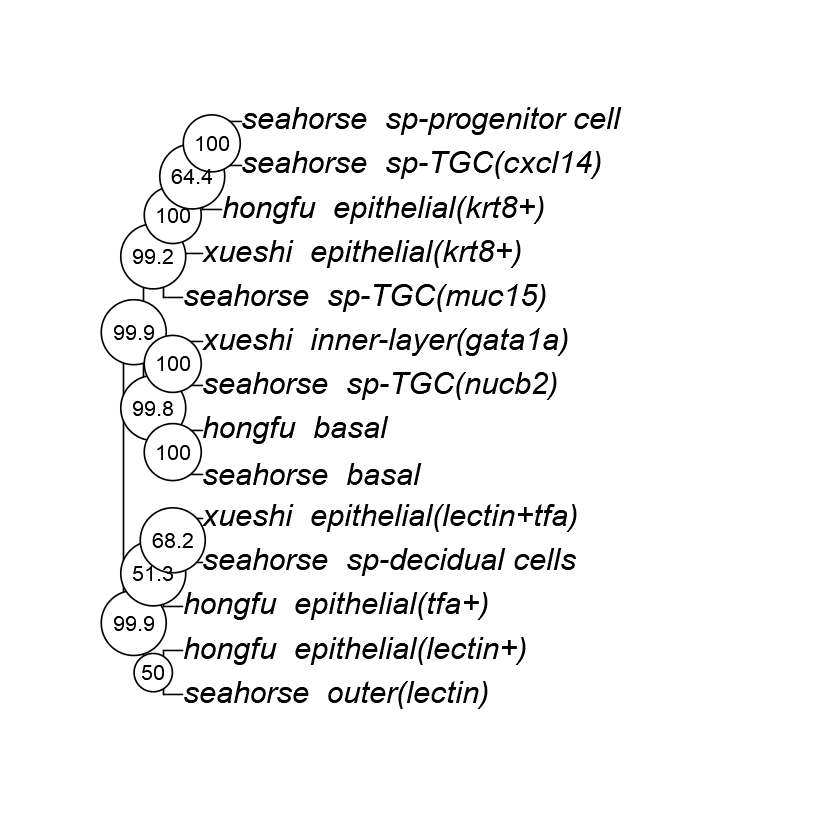

In [65]:
support <- getTreeSupport(tree_vargenes_cooc$tree,mc_fp,all_var_75_ann,scale_branches=T)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"


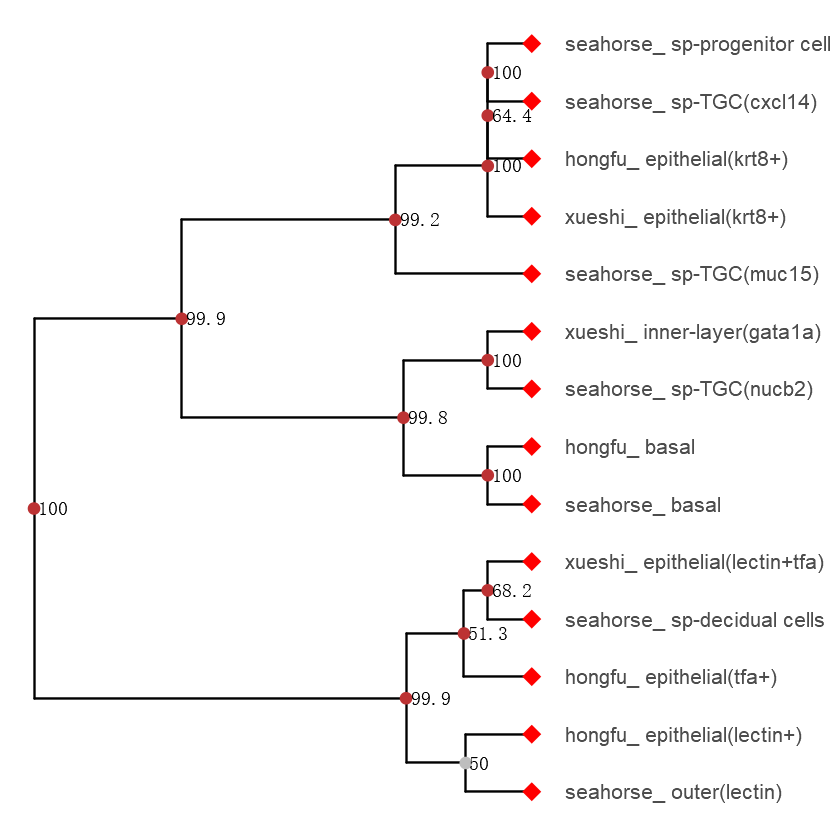

In [66]:
phy_tree_t20 <- tree_vargenes_cooc$tree
phy_tree_t20$node.label <- support/10

ggtree(phy_tree_t20,
       branch.length="branch.length") +
geom_nodepoint(color="#BC3233", alpha=1, size=2.5,aes(subset = !is.na(as.numeric(label)) & as.numeric(label) > 50)) +
geom_nodepoint(color="grey", alpha=1, size=2.5,aes(subset = !(!is.na(as.numeric(label)) & as.numeric(label) > 50))) +
geom_tippoint(color = 'red',shape = 18,size=5)+
geom_tiplab(as_ylab=TRUE,size=12) +#避免文字截断,但aes失效 
theme(legend.position = NaN)+
geom_nodelab(aes(label=label,
                 #subset = !is.na(as.numeric(label)) & as.numeric(label) > 50
                ), 
             hjust=-.05,
             size=4)+
ggsci::scale_colour_igv(alpha = 1)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"


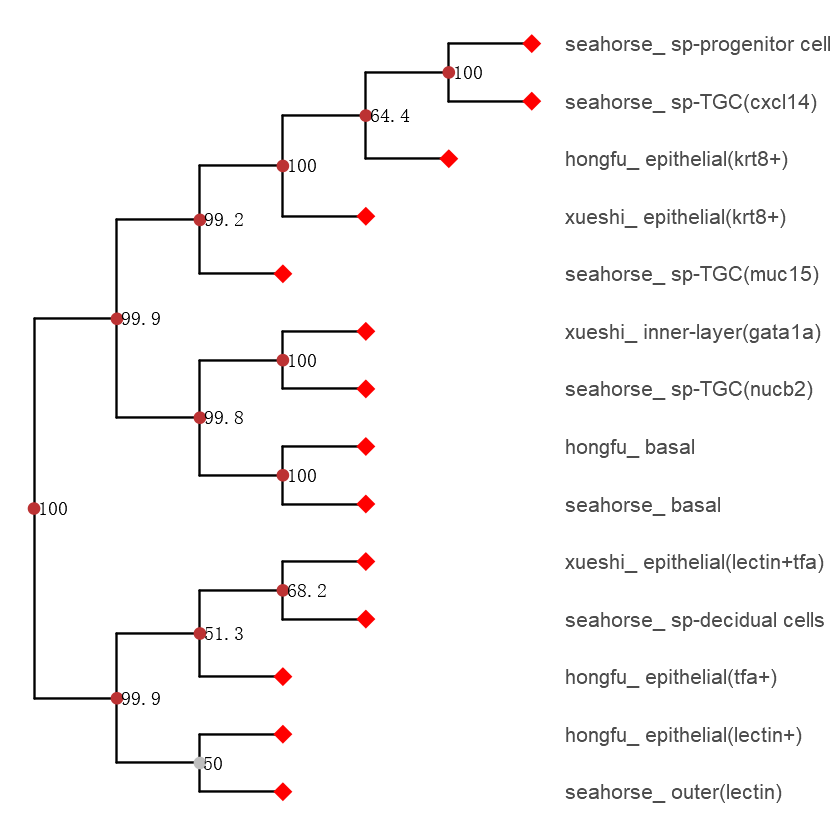

In [93]:

phy_tree_t20 <- ape::compute.brlen(tree_vargenes_cooc$tree, 1)
phy_tree_t20$node.label <- support/10

p <- ggtree(phy_tree_t20,
       branch.length="branch.length") +
geom_nodepoint(color="#BC3233", alpha=1, size=2.5,aes(subset = !is.na(as.numeric(label)) & as.numeric(label) > 50)) +
geom_nodepoint(color="grey", alpha=1, size=2.5,aes(subset = !(!is.na(as.numeric(label)) & as.numeric(label) > 50))) +
geom_tippoint(color = 'red',shape = 18,size=5)+
geom_tiplab(as_ylab=TRUE,size=12) +#避免文字截断,但aes失效 
theme(legend.position = NaN)+
geom_nodelab(aes(label=label,
                 #subset = !is.na(as.numeric(label)) & as.numeric(label) > 50
                ), 
             hjust=-.05,
             size=4)+
ggsci::scale_colour_igv(alpha = 1)

p

In [69]:
ggplot2::ggsave(p,filename = 'tree_final_test611.pdf',width = 10,height = 10)

Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"
Warning message in FUN(X[[i]], ...):
"强制改变过程中产生了NA"


In [70]:
ape::write.tree(phy_tree_t20, file = "Final_tree611.nwk", append = FALSE,
           digits = 10, tree.names = FALSE)

In [91]:
phy_tree_t20


Phylogenetic tree with 14 tips and 12 internal nodes.

Tip labels:
  seahorse_ basal, seahorse_ sp-TGC(cxcl14), seahorse_ sp-decidual cells, seahorse_ sp-progenitor cell, seahorse_ sp-TGC(muc15), seahorse_ outer(lectin), ...
Node labels:
  1, 2, 3, 4, 5, 6, ...

Unrooted; includes branch lengths.

In [97]:

#' Get gap genes for internal nodes in a tree
#' 
#' @param tree
#' @param feature_matrix, rows should be features (genes or motifs) and columns should be 
#'   tips of the tree; data should be log2 scaled
# @param feature_inclusion_ths numeric, threshold to consider a feature (gene, motif) (default: 1)
#' @param branch_length_ths numeric, threshold for selecting long branches (default: 0.1)
#' @param feature_in_thrs min threshold median value for feature in 
#'   the columns of feature_matrix in the selected node split
#' @param feature_out_thrs max threshold median value for features in 
#'   the columns of feature_matrix outside of selected node split
#' @param method,methodbg character, "absolute" or "median"
#' @param ncores integer (default: `detectCores()-1`)
#' @param verbose logical (default: FALSE)
#' 
tree_gap_genes <- function(
  tree, feature_matrix, branch_length_thrs=0.1,
  feature_in_thrs = 1.5, feature_out_thrs = 1,
  method="absolute", methodbg="absolute", abs_leakyness=0, abs_leakynessbg=0.05,
  ncores=detectCores()-1, verbose=FALSE
) {
  
  # get tree data
  tree_tb=as_tibble(tree)
  treet=tidytree::as.treedata(tree)
  
  # get the order of the tips
  tip_labels <- treet@phylo$tip.label
  is_tip <- treet@phylo$edge[,2] <= length(tip_labels)
  ordered_tips <- treet@phylo$edge[is_tip, 2]
  
  # get the ordered tip labels
  tip_labels <- treet@phylo$tip.label[ordered_tips]
  
  # select iternal nodes with large branch lengths. CRITICAL!!
  # (start at n_tips + 2 (because the first internal node is the whole tree!)
  nodes <- 1:nrow(tree_tb)
  nodes_above_ths <- tree_tb$branch.length[(length(tip_labels)+2):nrow(tree_tb)] > branch_length_thrs
  long_nodes <- which(nodes_above_ths)+length(tip_labels)+1
  
  calc_nodes=c(ordered_tips,long_nodes)
  
  # matrix to store the binary split info  1/0
  m_splits=matrix(0,ncol=length(tip_labels),nrow=length(calc_nodes))
  colnames(m_splits)=tip_labels
  rownames(m_splits)=calc_nodes #1:nrow(m_splits)
  # list to store the enriched feature in the tips under the node vs all other tips
  top_features=vector("list",length=length(nodes))
  # list to store the enriched features in the tips under the node vs sister clade (branching from mrca)
  top_feature_sister=vector("list",length=length(nodes))
  # list to store the anti-enriched features (or enriched oustide) the node
  top_feature_anti=vector("list",length=length(nodes))
  
  # require(foreach)
  # require(doParallel)
  # maxcores <- detectCores()
  # if (ncores > maxcores) {
  #   warning(sprintf(
  #     "Specified numer of cores (%s) exceeds the number of available cores (%s)!\nContinuing using %s cores.",
  #     ncores, maxcores, maxcores
  #   ))
  #   ncores=maxcores
  # }
  #registerDoParallel(ncores)
  #i=0
  #foreach (node=nodes) %dopar% {
  for(node in nodes){
    message(node)
    if (node %in% calc_nodes) {
      if (verbose==TRUE) print(sprintf("Starting analysis for node %s", node))
      #i=i+1
      i=match(node,calc_nodes)
      node_parent <- treeio::parent(tree,node)
      node_children <- treeio::child(tree,node_parent)
      node_sibling <- setdiff(node_children,node)
      if (node %in% ordered_tips) {
        tips_in <- tip_labels[node]
      } else {
        tips_in <- treeio::tree_subset(treet,node,levels_back=0)@phylo$tip.label
      }
      if (verbose==TRUE) print(sprintf("Tips in: %s", paste(tips_in,collapse=", ")))
      sister_label <- tree_tb[tree_tb$node%in%node_sibling,]$label
      tips_sister <- tryCatch({
        if (any(!is.na(sister_label))) {
          sister_label[!is.na(sister_label)]
        } else {
          unlist(lapply(node_sibling, function(node_sibling) 
            treeio::tree_subset(treet,node_sibling,levels_back=0)@phylo$tip.label
          ))
        }
      })#, error=function(e) NULL)
      if (verbose==TRUE) print(sprintf("Sister tips: %s", paste(tips_sister,collapse=", ")))
      tips_out <- setdiff(treet@phylo$tip.label,tips_in)
      if (verbose==TRUE) print(sprintf("Out tips: %s", paste(tips_out,collapse=", ")))
      
      # fill the reference split matrix
      m_splits[i,tips_in] <- 2
      m_splits[i,tips_out] <- 1
      .calc_leakyness <- function(abs_leakyness,n) {
        if (abs_leakyness<1) {
          pmin(round(c(1-abs_leakyness)*n), n)
        } else {
          pmin(round(n-abs_leakyness), n)
        }
      }
      if (method=="median") {
        fin=apply(feature_matrix[,tips_in,drop=F],1,median) > feature_in_thrs
        fin_inv=apply(feature_matrix[,tips_out,drop=F],1,median) > feature_in_thrs
      } else if (method=="absolute") {
        fin=apply(feature_matrix[,tips_in,drop=F], 1, function(x) 
          #all(x > feature_in_thrs)
          !(sum(x > feature_in_thrs) < .calc_leakyness(abs_leakyness,n=length(tips_in)))
        )
        fin_inv=apply(feature_matrix[,tips_out,drop=F], 1, function(x) 
          #all(x > feature_in_thrs)
          !(sum(x > feature_in_thrs) <  .calc_leakyness(abs_leakyness,n=length(tips_out)))
        )
      }
      if (methodbg=="median") {
        fout=apply(feature_matrix[,tips_out,drop=F],1,median) < feature_out_thrs
        fout_inv=apply(feature_matrix[,tips_in,drop=F],1,median) < feature_out_thrs
        fout_sister=apply(feature_matrix[,tips_sister,drop=F],1,median) < feature_out_thrs
      } else if (methodbg=="absolute") {
        fout=apply(feature_matrix[,tips_out,drop=F], 1, function(x) 
          #all(x < feature_out_thrs)
          !(sum(x < feature_out_thrs) < .calc_leakyness(abs_leakynessbg,n=length(tips_out)))
        )
        fout_inv=apply(feature_matrix[,tips_in,drop=F], 1, function(x) 
          #all(x < feature_out_thrs)
          !(sum(x < feature_out_thrs) < .calc_leakyness(abs_leakynessbg,n=length(tips_in)))
        )
        fout_sister=apply(feature_matrix[,tips_sister,drop=F], 1, function(x) 
          #all(x < feature_out_thrs)
          !(sum(x < feature_out_thrs) < .calc_leakyness(abs_leakynessbg,n=length(tips_sister)))
        )
      }
      
      f_in=which(fin & fout)
      f_sister=which(fin & fout_sister)
      f_out=which(fin_inv & fout_inv)
      
      # now add each feature to the corresponding list (or "none")
      if(length(f_in)>0){
        top_feat=rownames(feature_matrix)[f_in]
        if(length(f_in)>1)
          top_feat=top_feat[order(apply(feature_matrix[top_feat,tips_in,drop=F],1,median),decreasing=T)] 
        top_features[[node]]=top_feat
      } else { top_features[[node]]="NONE"}	
      
      if(length(f_sister)>0){
        top_feat=rownames(feature_matrix)[f_sister]
        if(length(f_sister)>1)
          top_feat=top_feat[order(apply(feature_matrix[top_feat,tips_in,drop=F],1,median),decreasing=T)] 
        top_feature_sister[[node]]=top_feat
      } else { top_feature_sister[[node]]="NONE"}	
      
      if(length(f_out)>0){
        top_anti=rownames(feature_matrix)[f_out]
        if(length(f_out)>1)
          top_anti=top_anti[order(apply(feature_matrix[top_anti,tips_out,drop=F],1,median),decreasing=T)]
        top_feature_anti[[node]]=top_anti
      } else { top_feature_anti[[node]]="NONE"}
      
      if (verbose==TRUE) print(sprintf("Finished analysis for node %s", node))
      
    } else {
      if (verbose==TRUE) 
        print(sprintf(
          "Node %s is shorther than threshold branch length (%s); skipping.", 
          node, branch_length_thrs
        ))
      top_features[[node]] <- "NOT CALCULATED"
      top_feature_sister[[node]] <- "NOT CALCULATED"
      top_feature_anti[[node]] <- "NOT CALCULATED"
    }
  }
  #stopImplicitCluster()
  hm <- ComplexHeatmap::Heatmap(
    m_splits, col=c("0"="gray88","1"="lightgrey","2"="black"), show_heatmap_legend=FALSE,
    border = TRUE, rect_gp = grid::gpar(col="gray80"),
    cluster_columns = FALSE, cluster_rows = FALSE
  )
  
  # top_features_v <- vector("list",nrow(tree_tb))
  # top_feature_anti_v <- vector("list",nrow(tree_tb))
  # for (i in 1:length(calc_nodes)) {
  #   ln <- calc_nodes[i]
  #   top_features_v[[ln]] <- top_features[[i]]
  #   top_feature_anti_v[[ln]] <- top_feature_anti[[i]]
  # }
  
  return(list(
    top_features=top_features, 
    top_feature_anti=top_feature_anti, 
    top_feature_sister=top_feature_sister,
    splits_mat=m_splits, heatmap=hm
  ))
}


In [98]:
as_tibble(tree_vargenes_cooc$tree)

parent,node,branch.length,label
<int>,<int>,<dbl>,<chr>
21,1,1.088944e+02,seahorse_ basal
27,2,1.088944e+02,seahorse_ sp-TGC(cxcl14)
25,3,1.088944e+02,seahorse_ sp-decidual cells
27,4,1.088944e+02,seahorse_ sp-progenitor cell
19,5,3.378361e+02,seahorse_ sp-TGC(muc15)
23,6,1.633417e+02,seahorse_ outer(lectin)
22,7,1.088944e+02,seahorse_ sp-TGC(nucb2)
23,8,1.633417e+02,hongfu_ epithelial(lectin+)
26,9,1.088944e+02,hongfu_ epithelial(krt8+)


In [100]:
gap_genes <- tree_gap_genes(
          tree = tree_vargenes_cooc$tree, feature_matrix = abs(mc_fp),
          branch_length_thrs = 0.01,
          feature_in_thrs = log2(1.2), feature_out_thrs = 10,
        method="absolute", methodbg="absolute",
        abs_leakyness=0.1, abs_leakynessbg=0.1,
          verbose = FALSE, ncores=1
        )

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27



In [101]:
gap_genes$top_features[15:27]

[[1]]
[1] "NOT CALCULATED"

[[2]]
 [1] "apoeb"         "igfbp7"        "krt99"         "krt8"         
 [5] "s100w"         "spaca4l"       "tp63"          "crip1"        
 [9] "myh9a"         "zgc:123217"    "myof"          "agrn"         
[13] "itgb4"         "mpx"           "capgb"         "apnl"         
[17] "apnl"          "col17a1a"      "col4a6"        "LAMB3"        
[21] "DHDH"          "col4a5"        "dspb"          "atp5mc1"      
[25] "cav1"          "plcg2"         "tln1"          "dusp1"        
[29] "lipg"          "elf3"          "mdh1aa"        "si:dkey-4e7.3"

[[3]]
[1] "NONE"

[[4]]
[1] "NONE"

[[5]]
 [1] "apoeb"      "igfbp7"     "itga6b"     "cldni"      "spaca4l"   
 [6] "itgb4"      "apnl"       "apnl"       "myh9a"      "ADCY4"     
[11] "p4ha1a"     "col4a6"     "zgc:123217" "capgb"      "s100w"     
[16] "LAMC2"      "col17a1a"   "noxa1"      "col4a5"     "plcg2"     
[21] "hsd17b12a"  "cav1"       "rgs2"       "nox1"       "GLO1"      
[26] "krt8"       "tp63"       "dnase1l1"   "EPX"        "spock3"    
[31] "tln1"       "slc35c2"    "lipg"       "elf3"       "wnt10a"    
[36] "sqstm1"     "DHDH"       "rab25b"     "fat2"       "cldnb"     
[41] "GPRC5D"     "npdc1a"     "prdm1b"     "crip1"     

[[6]]
 [1] "apoeb"     "igfbp7"    "itga6b"    "itgb4"     "spaca4l"   "apnl"     
 [7] "apnl"      "myh9a"     "ADCY4"     "col4a5"    "col4a6"    "s100w"    
[13] "GLO1"      "col17a1a"  "tp63"      "hsd17b12a" "cav1"      "slc35c2"  
[19] "fat2"      "tln1"      "lipg"      "wnt10a"   

[[7]]
 [1] "eef1a1l1"   "tubb2b"     "ube2c"      "hmgn6"      "mki67"     
 [6] "nusap1"     "H2AZ1"      "tpx2"       "STMN1"      "cenpf"     
[11] "h3f3d"      "hmgb2b"     "smc4"       "s100w"      "RRM2"      
[16] "sqstm1"     "top2a"      "pclaf"      "rgs2"       "snrpd2"    
[21] "cdk1"       "tubb5"      "kif11"      "pcna"       "magoh"     
[26] "noxo1a"     "ankib1a"    "snu13a"     "hnrnpa1b"   "ADCY4"     
[31] "aspm"       "PLK1"       "zgc:123217" "p4ha1a"     "nox1"      
[36] "ilf2"       "snrpb2"     "snrpd3l"    "HNRNPA0"    "tp63"      
[41] "cbx5"       "MYO10"      "notch3"     "ccnb1"      "mad2l1"    
[46] "rpa2"       "CBX1"       "cd81a"      "nuf2"       "SMARCA4"   
[51] "rpa3"       "elf3"       "rtkn2a"     "lbr"        "apex1"     
[56] "hspd1"      "zgc:86896"  "cdca8"      "pttg1"      "ranbp1"    
[61] "nfkbiaa"    "pim1"       "noxa1"      "c1qbp"      "chl1a"     
[66] "chaf1a"     "rrm1"       "nop58"      "plcg2"      "EPX"       
[71] "mcm7"       "rpa1"       "CLSPN"      "selenoh"    "rab25b"    
[76] "TCF4"       "lrp1ab"     "fat2"       "myo1b"     

[[8]]
 [1] "hbbe2"   "mibp2"   "blvrb"   "aqp1a.1" "alas2"   "epb41a"  "gp1bb"  
 [8] "slc4a1a" "hemgn"   "tmod4"   "lmo2"    "prdx2"  

[[9]]
 [1] "krt99"      "s100w"      "krt8"       "zgc:123217" "glulc"     
 [6] "agrn"       "tubb2b"     "apoeb"      "TGM6"       "hsp90aa1.1"
[11] "itgb4"      "igfbp7"     "spaca4l"    "capgb"      "p3h2"      
[16] "EGR3"       "tp63"       "myof"       "apnl"       "plcg2"     
[21] "dusp1"      "LAMB3"      "DHDH"       "mpx"        "mdh1aa"    
[26] "ctsla"      "tpi1b"      "ssuh2rs1"   "hmgb2b"     "her6"      
[31] "elf3"       "ATP5MC2"    "ldha"       "myh9a"      "lipg"      
[36] "cav1"      

[[10]]
 [1] "igfbp7"        "apoeb"         "spaca4l"       "myh9a"        
 [5] "col4a5"        "tp63"          "hsd17b12a"     "apnl"         
 [9] "apnl"          "dspb"          "s100w"         "col4a6"       
[13] "crip1"         "GLO1"          "itgb4"         "LAMB3"        
[17] "capgb"         "col17a1a"      "cav1"          "atp5mc1"      
[21] "tln1"          "si:dkey-4e7.3"

[[11]]
 [1] "igfbp7"           "apoeb"            "itga6b"           "cldni"           
 [5] "myh9a"            "col4a5"           "itgb4"            "spock3"          
 [9] "col17a1a"         "apnl"             "apnl"             "tnfrsf9a"        
[13] "col4a6"           "p2rx1"            "spaca4l"    

In [102]:
func_3 <- function(x,ls){
    max_len <- max(unlist(lapply(ls,length)))
    
    if(x[1] == 'NONE'){
        return(rep(NA,times = max_len))
    }else if (length(x) < max_len){
        return(c(x,rep(NA,times = max_len - length(x))))
    }else{
        return(x)
    }
}

func_4 <- function(x){
    if( x[[1]] != 'NOT CALCULATED' & x[[1]] != 'NONE'){
        gene <- ann_rev[x,'gene'] %>% na.omit()
        id <- ann_rev[x,'genename'] %>% na.omit()
        paste(gene,id,sep = '|')
    }else{
        x
    }
}

In [103]:
ann_rev <- ann
ann_rev <- ann_rev[!duplicated(ann_rev$genename),]
rownames(ann_rev) <- ann_rev$genename

In [104]:
save_gap_genes <- gap_genes$top_features[15:27]
save_gap_genes_id <- lapply(save_gap_genes,func_4)

save_gap_df <- save_gap_genes_id %>% 
    lapply(.,FUN = func_3,ls = .) %>%
    as.data.frame()

colnames(save_gap_df) <- paste('Node',1:12)

write.table(save_gap_df,'NOT_UNROOT_Final_node_supporting_genes_inter12_NoOutCutOff_ID.csv',col.names = T,row.names = F,sep = ',',quote = T,na = '')